In [1]:
# %reset
# %load_ext autoreload
# %autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from info.utils.pdf_computer import pdfComputer
from info.models.logistic_network import Logistic
from info.core.info import info

# %matplotlib inline

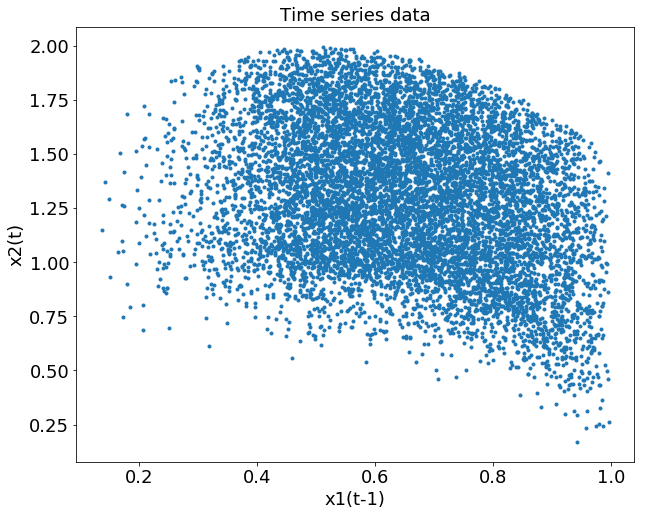

In [3]:
# Test
# x2(t) = 4*x1(t-1)*(1-x(t-1)); x1(t)~U[0,1]

# The number of bins in each dimension
n1, n2, n3 = 20, 25, 30

# Settings for plot
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Generate the variable values
n    = 3
lag  = 1
e    = 1
ez   = .5
adjM = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
lagM = np.array([[0, lag, lag], [lag, 0, lag], [lag, lag, 0]])

# Parameters for simulation
nstep = 10000
noiseType = 'additive'
noiseDist = 'uniform'
noiseOn   = [1, 1, 1]
noisePara = [1, 0, 1]

# Generate the outputs
logistic = Logistic(n, adjM, lagM, e, ez, noiseType=noiseType, 
                    noiseDist=noiseDist, noisePara=noisePara)
results = logistic.simulate(nstep)
d1, d2 = results[0,: ], results[1, :]*2

# Plot
t = range(nstep)
# plt.plot(t, results[0, :], 'b')
# plt.plot(t, results[1, :], 'k')
plt.plot(d1[:-lag],d2[lag:],'.')
plt.title('Time series data')
plt.xlabel('x1(t-1)')
plt.ylabel('x2(t)')
plt.show()
# # Save
# np.savetxt('data.csv',results,delimiter=',')

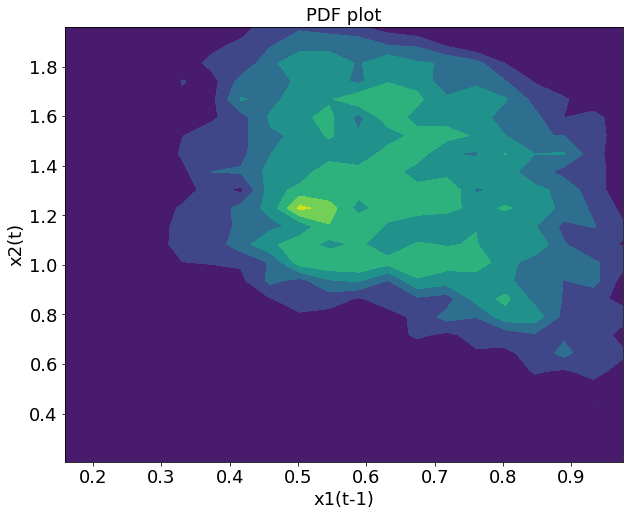

/Users/Ben1897/Documents/research/code/info/info/core/info.py:274: RuntimeWarning: invalid value encountered in divide
  ypdfs_x_log, ypdfs_x = np.ma.log(xypdfs/xpdfs), np.ma.divide(xypdfs, xpdfs)
/Users/Ben1897/Documents/research/code/info/info/core/info.py:304: RuntimeWarning: invalid value encountered in divide
  ixypdf_log = np.ma.log(pdfs/(xpdfs*ypdfs))


H(X)      3.946949
H(Y)      4.175261
H(X|Y)    3.773422
H(Y|X)    4.001734
I(X;Y)    0.173527
dtype: float64

In [4]:
# Rearrange the results with the lag
results1 = np.array([d1[:-lag],d2[lag:]]).T

# Calculate the PDF
pdfsolver1 = pdfComputer(ndim=2, approach='kde', 
                         bandwidth='silverman', kernel='epanechnikov', base=2)
_, pdf1, cd = pdfsolver1.computePDF(results1, nbins=[n1,n2])

# Plot
xv, yv = np.meshgrid(cd[0], cd[1], indexing='ij')
plt.contourf(xv, yv, pdf1)
plt.title('PDF plot')
plt.xlabel('x1(t-1)')
plt.ylabel('x2(t)')
plt.show()

# Calculate the INFO
test1_info = info(pdf1)
test1_info.allInfo

/Users/Ben1897/Documents/research/code/info/info/core/info.py:340: RuntimeWarning: invalid value encountered in divide
  txypdf_log = np.ma.log(pdfs*factor1/(factor2*factor3))


II          0.589137
Itotal      0.842749
R(Z;Y,X)    0.000995
S(Z;Y,X)    0.590132
U(Z,X)      0.058509
U(Z,Y)      0.193112
Rmin        0.000000
Isource     0.016729
RMMI        0.059504
dtype: float64


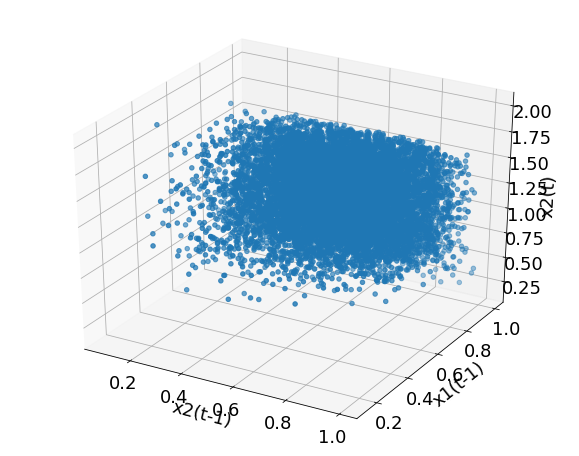

In [5]:
# 3D
# Rearrange the results with the lag
X, Y, Z = d2[:-lag]*.5, d1[:-lag], d2[lag:]
results2 = np.array([X, Y, Z]).T

# Calculate the PDF
pdfsolver2 = pdfComputer(ndim=3, approach='kde', bandwidth='silverman', kernel='epanechnikov')
_, pdf2, cd = pdfsolver2.computePDF(results2, nbins=[n1,n2,n3])
# xv, yv = np.meshgrid(cd[0], cd[2], indexing='ij')
# plt.contourf(xv, yv, np.sum(pdf2,axis=(1)))

# Calculate the INFO
test2_info = info(pdf2)
print test2_info.allInfo

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z)
ax.set_xlabel('x2(t-1)')
ax.set_ylabel('x1(t-1)')
ax.set_zlabel('x2(t)')
plt.show()

In [6]:
# def transferEntropy(pdf):
#     nx, ny, nz = pdf.shape
#     # Calculate
#     xpdfs = np.sum(pdf, axis=(1,2))
#     xzpdfs = np.sum(pdf, axis=(1))
#     xypdfs = np.sum(pdf, axis=(2))
#     print xpdfs.shape, xzpdfs.shape, xypdfs.shape
#     # Expand zpdfs, xzpdfs, yzpdfs to the shape (nx, ny, nz)
#     xpdfs  = np.tile(xpdfs[:, np.newaxis, np.newaxis], [1, ny, nz])
#     xzpdfs = np.tile(xzpdfs[:, np.newaxis, :], [1, ny, 1])
#     xypdfs = np.tile(xypdfs[:, :, np.newaxis], [1, 1, nz])
    
#     txypdf_log = np.ma.log(pdf*xpdfs/(xzpdfs*xypdfs))
#     txypdf_log = txypdf_log.filled(0)
    
#     txypdf = pdf*txypdf_log
    
#     return np.sum(txypdf)
    
# transferEntropy(pdf2)

In [7]:
# plt.subplot(3,1,1)
# xv, zv = np.meshgrid(cd[0], cd[2], indexing='ij')
# plt.contourf(xv, zv, np.sum(pdf2,axis=(1)))
# plt.subplot(3,1,2)
# xv, yv = np.meshgrid(cd[0], cd[1], indexing='ij')
# plt.contourf(xv, yv, np.sum(pdf2,axis=(2)))
# plt.subplot(3,1,3)
# yv, zv = np.meshgrid(cd[1], cd[2], indexing='ij')
# plt.contourf(yv, zv, np.sum(pdf2,axis=(0)))

In [8]:
# from scipy.stats import entropy
# import sklearn.metrics as me
# def mi(pdf, base=2):
#     xpdf = np.sum(pdf, axis=1)
#     ypdf = np.sum(pdf, axis=0)
    
#     return entropy(xpdf,base=base)+entropy(ypdf,base=base)- \
#            entropy(pdf.reshape(pdf.size),base=base)
    
# base=np.e
# print me.mutual_info_score(d1[:-lag], d2[lag:])
# pdfsolver1 = pdfComputer(ndim=2, approach='kde', 
#                          bandwidth='silverman', kernel='epanechnikov')
# _, pdf1, cd = pdfsolver1.computePDF(results1)
# test1_info = info(pdf1, base=base)
# print test1_info.allInfo
# print mi(pdf1, base=base)

# labels_a = np.array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])
# labels_b = np.array([1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 1, 3, 3, 3, 2, 2])
# results3 = np.array([labels_a, labels_b]).T
# print me.mutual_info_score(labels_a, labels_b)
# pdfsolver1 = pdfComputer(ndim=2, approach='kde', 
#                          bandwidth='silverman', kernel='epanechnikov')
# _, pdf1, cd = pdfsolver1.computePDF(results3)
# test1_info = info(pdf1, base=base)
# print test1_info.allInfo
# print mi(pdf1, base=base)

In [9]:
results

array([[ 0.24434701,  0.49704273,  0.4564696 , ...,  0.59499592,
         0.48141732,  0.68107817],
       [ 0.53936263,  0.79286164,  0.66396756, ...,  0.32039714,
         0.73891051,  0.56960915],
       [ 0.5695438 ,  0.70255385,  0.84539509, ...,  0.66228187,
         0.68396923,  0.66934539]])